# Train a deep learning model on B-G-R-NIR Sentinel-2 images

The notebook:

 * splits the dataset into training and validation
 * loads images and labels from eopatches over different time-stamps
 * saves training and cros--validation data into npz files locally
 * performs training by loading the npz files 
 * re-loads model and computes scores on cval set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import json
from pathlib import Path
import logging
from datetime import datetime

import numpy as np
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt

from eoflow.input.operations import augment_data
from tensorflow.python.keras.utils.layer_utils import print_summary

In [3]:
from fs_s3fs import S3FS

# Basic config 

In [4]:
filesystem = S3FS("bucket-name", 
              aws_access_key_id="",
              aws_secret_access_key="",
              region="eu-central-1") 

In [5]:
BASE_S3_PATH = 'data/Lithuania'
METADATA_PATH = os.path.join(BASE_S3_PATH, 'patchlets_meta')
NPZ_FOLDER_LOCAL = '/home/ubuntu/training_npz'
MODEL_DIR = '/home/ubuntu/model'

NPZ_FOLDER_S3 = 'data/Lithuania/patchlets_npz' 
### Train/Test/Validation folders, data should be copied from here locally due to speed 

PATCHLETS_META_FOLDER = 'data/Lithuania/patchlets_meta/'

In [6]:
logging.getLogger('tensorflow').disabled = True
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Dataset map functions 

In [7]:
from tf_data_utils import Unpack, ToFloat32, Normalize, FillNaN, OneMinusEncoding, LabelsToDict
from tf_data_utils import normalize_perc, normalize_meanstd, augment_data, npz_dir_dataset

### Constants

In [8]:
height, width, nchannels = 256, 256, 4

n_classes = 2

batch_size = 8

# 65k in training? 
# this should be set so that batch_size * iterations_per_epoch covers roughly the whole dataset in 1 epoch
iterations_per_epoch = 65000 // batch_size

num_epochs = 15

# Config 

In [9]:
# !wandb login ""

wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc
Successfully logged in to Weights & Biases!


In [10]:
# Randomly augment the data
feature_augmentations = ['flip_left_right', 'flip_up_down', 'rotate', 'brightness']
label_augmentations = ['flip_left_right', 'flip_up_down', 'rotate']

## Create datasets 

In [11]:
normalise = 'to_std' # or 'to_std'

if normalise == 'to_perc':
    normaliser = normalize_perc
elif normalise == 'to_std':
    normaliser = normalize_meanstd

In [12]:
train = npz_dir_dataset(os.path.join(NPZ_FOLDER_LOCAL, 'train'), 
                        dict(X='features', y_extent='y_extent', y_boundary='y_boundary', y_distance='y_distance'), 
                        num_parallel=20)
cval = npz_dir_dataset(os.path.join(NPZ_FOLDER_LOCAL, 'validation'), 
                       dict(X='features', y_extent='y_extent', y_boundary='y_boundary', y_distance='y_distance'), 
                       num_parallel=43)
# test = npz_dir_dataset(os.path.join(NPZ_FOLDER_LOCAL, 'test'), 
#                        dict(X='features', y_extent='y_extent', y_boundary='y_boundary', y_distance='y_distance'), 
#                        num_parallel=10)

In [13]:
train_dataset = train
train_dataset = train_dataset.map(normaliser)
train_dataset = train_dataset.map(Unpack())
train_dataset = train_dataset.map(ToFloat32())
train_dataset = train_dataset.map(augment_data(feature_augmentations, label_augmentations))
train_dataset = train_dataset.map(FillNaN(fill_value=-2))
train_dataset = train_dataset.map(OneMinusEncoding(n_classes=n_classes))
train_dataset = train_dataset.map(LabelsToDict(['extent','boundary','distance']))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___augment.<locals>.<lambda> at 0x7f1e2d8ac268>. It was defined on this line: operations = {'flip_left_right': (lambda x: ag__.converted_call(tf.cond, (flip_lr_cond, (lambda : ag__.converted_call(tf.image.flip_left_right, (x,), None, fscope)), (lambda : x)), None, fscope)), 'flip_up_down': (lambda x: ag__.converted_call(tf.cond, (flip_ud_cond, (lambda : ag__.converted_call(tf.image.flip_up_down, (x,), None, fscope)), (lambda : x)), None, fscope)), 'rotate': (lambda x: ag__.converted_call(tf.image.rot90, (x, rot90_amount), None, fscope)), 'brightness': (lambda x: ag__.converted_call(tf.image.random_brightness, (x, brightness_delta), None, fscope)), 'contrast': (lambda x: ag__.converted_cal

In [14]:
ds_1 = next(iter(train_dataset))

In [15]:
feats = ds_1[0]
lbls = ds_1[1]

In [16]:
feats['features'].shape, lbls['extent'].shape, lbls['boundary'].shape, lbls['distance'].shape 

(TensorShape([8, 256, 256, 4]),
 TensorShape([8, 256, 256, 2]),
 TensorShape([8, 256, 256, 2]),
 TensorShape([8, 256, 256, 2]))

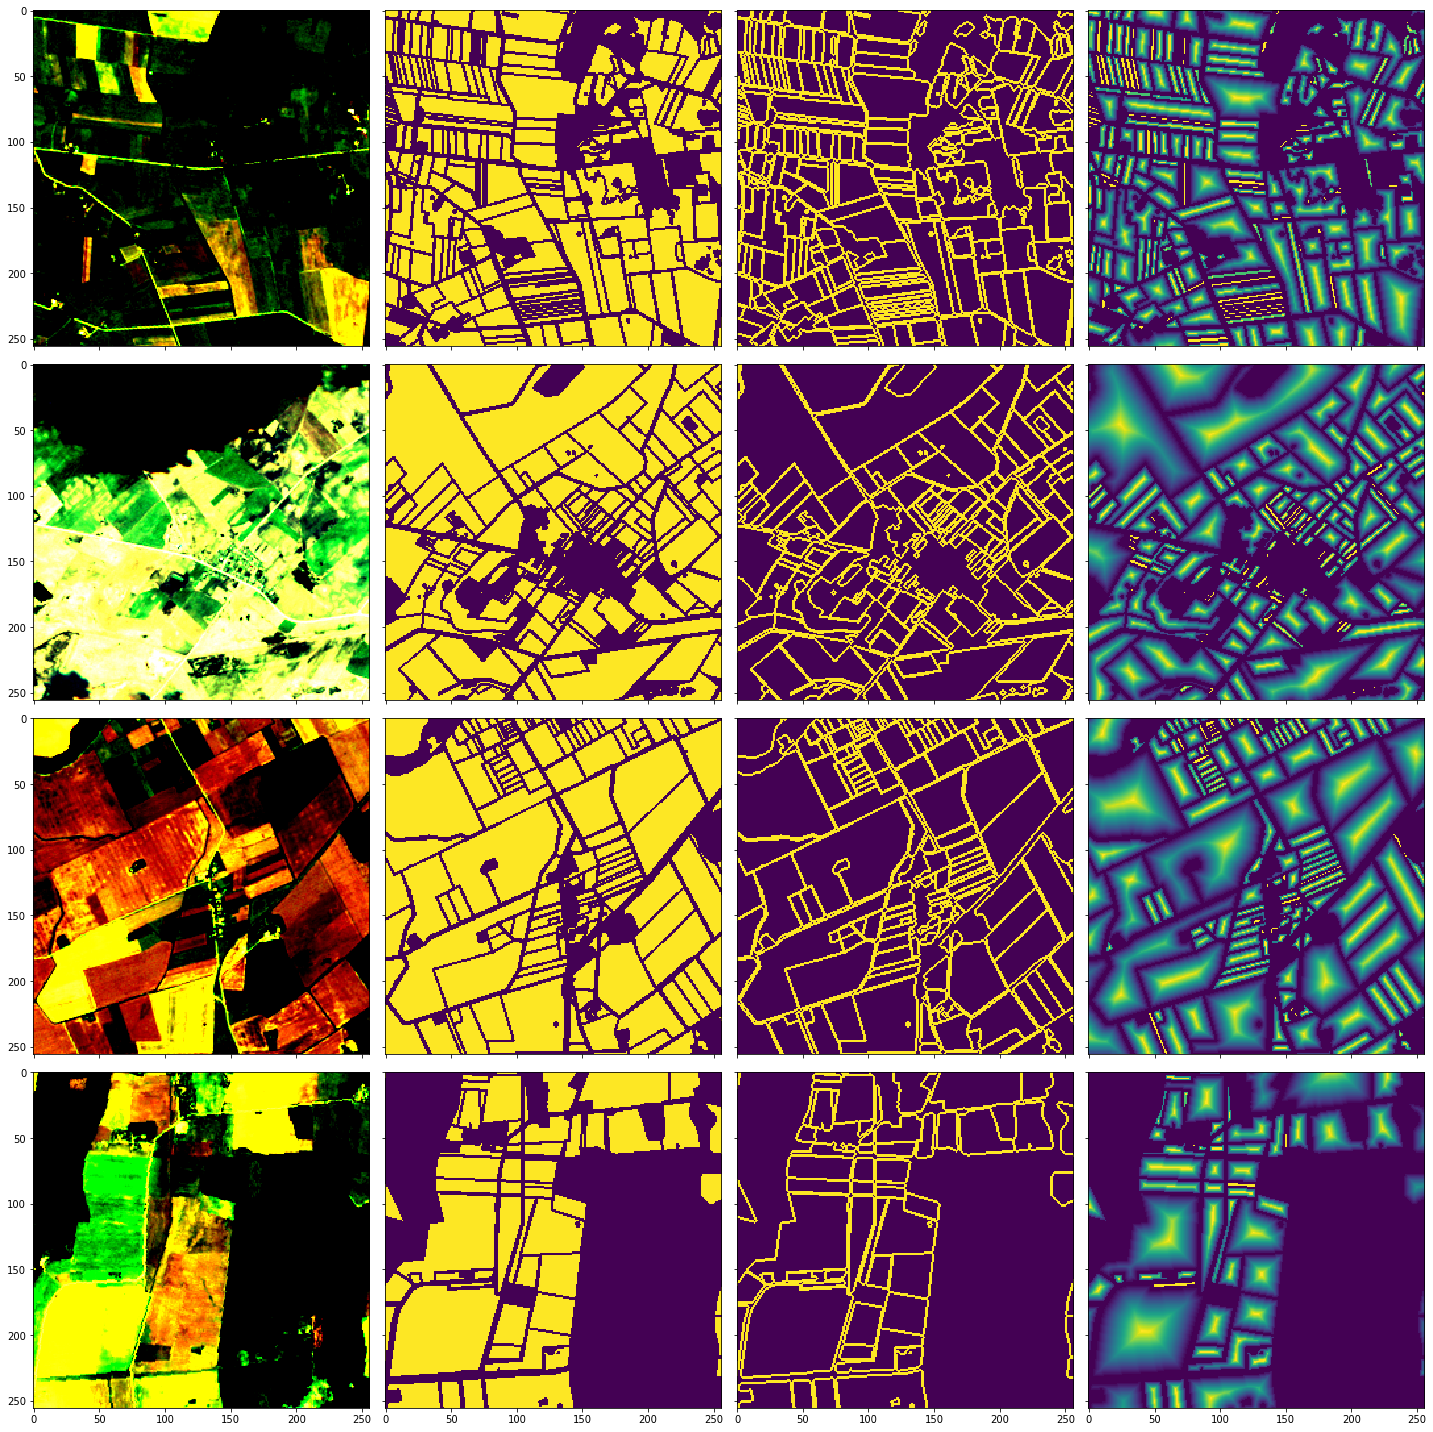

In [17]:
fig, axs = plt.subplots(nrows=4, ncols=4, sharex='all', sharey='all', figsize=(20, 20))

for nb in np.arange(4):
    axs[nb][0].imshow(feats['features'].numpy()[nb][...,[2,1,0]])
    axs[nb][1].imshow(lbls['extent'].numpy()[nb][..., 1])
    axs[nb][2].imshow(lbls['boundary'].numpy()[nb][..., 1])
    axs[nb][3].imshow(lbls['distance'].numpy()[nb][..., 1])
    
plt.tight_layout()

In [18]:
cval_dataset = cval
cval_dataset = cval_dataset.map(normaliser)
cval_dataset = cval_dataset.map(Unpack())
cval_dataset = cval_dataset.map(FillNaN(fill_value=-2))
cval_dataset = cval_dataset.map(OneMinusEncoding(n_classes=n_classes))
cval_dataset = cval_dataset.map(LabelsToDict(['extent','boundary','distance']))
cval_dataset = cval_dataset.batch(batch_size)

### Set up model & Train 


In [19]:
from eoflow.models.losses import JaccardDistanceLoss, TanimotoDistanceLoss
from eoflow.models.segmentation_base import segmentation_metrics

from eoflow.models.metrics import MCCMetric

In [20]:
from niva_models import ResUnetA

In [21]:
from tf_viz_utils import ExtentBoundDistVisualizationCallback

In [22]:
# Model configuration
model_cfg = {
    "learning_rate": 0.01,
    "n_layers": 3,
    "n_classes": n_classes,
    "keep_prob": 0.8,
    "features_root": 32,
    "conv_size": 3,
    "conv_stride": 1,
    "dilation_rate": [1, 3, 15, 31],
    "deconv_size": 2,
    "add_dropout": True,
    "add_batch_norm": False,
    "use_bias": False,
    "bias_init": 0.0,
    "padding": "SAME",
    "pool_size": 3,
    "pool_stride": 2,
    "prediction_visualization": True,
    "class_weights": None
}
    
# Initialize model with configuration
model = ResUnetA(model_cfg)

In [23]:
model.build(dict(features=[None, height, width, nchannels]))

In [24]:
mcc_metric = MCCMetric(default_n_classes=n_classes, default_threshold=.5)
mcc_metric.init_from_config({'n_classes': n_classes})

Using default value for threshold: 0.5.


In [25]:
model.net.compile(loss={'extent':TanimotoDistanceLoss(),
                        'boundary':TanimotoDistanceLoss(),
                        'distance':TanimotoDistanceLoss()},
                  optimizer=tf.keras.optimizers.Adam(learning_rate=model.config.learning_rate),
                  metrics=[segmentation_metrics['accuracy'](), 
                          tf.keras.metrics.MeanIoU(num_classes=model_cfg['n_classes'])])

In [26]:
# print_summary(model)

In [27]:
now = datetime.now().isoformat(sep='-', timespec='seconds').replace(':', '-')
model_name = f'unet_{now}'
model_path = f'{MODEL_DIR}/{model_name}'

if not os.path.exists(model_path):
    os.makedirs(model_path)

logs_path = os.path.join(model_path, 'logs')
checkpoints_path = os.path.join(model_path, 'checkpoints', 'model.ckpt')

viz_dir = os.path.join(logs_path, 'viz')
ds = cval_dataset.unbatch().batch(8).take(1)
data = next(iter(ds))


# Tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_path,
                                                      update_freq='epoch',
                                                      profile_batch=0)

# Checkpoint saving callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoints_path,
                                                         save_best_only=True,
                                                         save_freq='epoch',
                                                         save_weights_only=True)

# Visualisation callback
visualisation_callback = ExtentBoundDistVisualizationCallback(data, viz_dir)

    
full_config = dict(**model_cfg, 
                   iterations_per_epoch=iterations_per_epoch, 
                   num_epochs=num_epochs, 
                   batch_size=batch_size,
                   model_name=model_name
                   )

with open(f'{model_path}/model_cfg.json', 'w') as jfile:
    json.dump(model_cfg, jfile)


In [28]:
import logging
logging.disable(logging.CRITICAL)

In [ ]:
# wandb.init(config=full_config, 
#            name=f'dperessutti-{model_name}',
#            project="niva-field-delineation", 
#            sync_tensorboard=True)

In [30]:
model.net.fit(train_dataset, 
              validation_data=cval_dataset,
              epochs=num_epochs,
              steps_per_epoch=iterations_per_epoch,
              callbacks=[tensorboard_callback, checkpoint_callback, visualisation_callback, WandbCallback()])

wandb: Wandb version 0.9.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/15
8125/8125 [==============================] - ETA: 0s - loss: 1.9874 - extent_loss: 0.6349 - boundary_loss: 0.8246 - distance_loss: 0.5279 - extent_accuracy: 0.8327 - extent_mean_io_u: 0.4754 - boundary_accuracy: 0.8216 - boundary_mean_io_u: 0.3433 - distance_accuracy: 0.8322 - distance_mean_io_u: 0.7221

wandb: ERROR Can't save model, h5py returned error: Layer Conv2D has arguments in `__init__` and therefore must override `get_config`.


8125/8125 [==============================] - 3807s 469ms/step - loss: 1.9874 - extent_loss: 0.6349 - boundary_loss: 0.8246 - distance_loss: 0.5279 - extent_accuracy: 0.8327 - extent_mean_io_u: 0.4754 - boundary_accuracy: 0.8216 - boundary_mean_io_u: 0.3433 - distance_accuracy: 0.8322 - distance_mean_io_u: 0.7221 - val_loss: 1.9864 - val_extent_loss: 0.6527 - val_boundary_loss: 0.8000 - val_distance_loss: 0.5337 - val_extent_accuracy: 0.8230 - val_extent_mean_io_u: 0.6031 - val_boundary_accuracy: 0.8336 - val_boundary_mean_io_u: 0.5281 - val_distance_accuracy: 0.8303 - val_distance_mean_io_u: 0.7304
Epoch 2/15
8125/8125 [==============================] - 3876s 477ms/step - loss: 1.8715 - extent_loss: 0.5916 - boundary_loss: 0.7849 - distance_loss: 0.4950 - extent_accuracy: 0.8597 - extent_mean_io_u: 0.6217 - boundary_accuracy: 0.8417 - boundary_mean_io_u: 0.4882 - distance_accuracy: 0.8496 - distance_mean_io_u: 0.7805 - val_loss: 1.9175 - val_extent_loss: 0.6192 - val_boundary_loss: 0.7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8125/8125 [==============================] - 3916s 482ms/step - loss: 1.7747 - extent_loss: 0.5551 - boundary_loss: 0.7490 - distance_loss: 0.4706 - extent_accuracy: 0.8810 - extent_mean_io_u: 0.7240 - boundary_accuracy: 0.8599 - boundary_mean_io_u: 0.6172 - distance_accuracy: 0.8660 - distance_mean_io_u: 0.7782 - val_loss: 1.7940 - val_extent_loss: 0.5652 - val_boundary_loss: 0.7420 - val_distance_loss: 0.4868 - val_extent_accuracy: 0.8755 - val_extent_mean_io_u: 0.7397 - val_boundary_accuracy: 0.8645 - val_boundary_mean_io_u: 0.6853 - val_distance_accuracy: 0.8565 - val_distance_mean_io_u: 0.7747
Epoch 14/15
8125/8125 [==============================] - 3898s 480ms/step - loss: 1.7721 - extent_loss: 0.5566 - boundary_loss: 0.7483 - distance_loss: 0.4672 - extent_accuracy: 0.8814 - extent_mean_io_u: 0.7265 - boundary_accuracy: 0.8606 - boundary_mean_io_u: 0.6177 - distance_accuracy: 0.8656 - distance_mean_io_u: 0.7758 - val_loss: 1.8048 - val_extent_loss: 0.5710 - val_boundary_loss: 0.

In [ ]:
# move model to bucket
#copy_tree(f'{wandb.run.dir}/checkpoints', f'{checkpoint_path}/checkpoints');
#copy_tree(f'{wandb.run.dir}/logs', f'{checkpoint_path}/logs');

# save entire model
# tf.keras.models.save_model(model, f'{checkpoint_path}/saved_model/', save_format='tf')

### Test loading of models

From checkpoint

In [58]:
# with open(f'{model_path}/model_cfg.json', 'r') as jfile:
#     new_model_cfg = json.load(jfile) 
    
# new_model = NivaModel(new_model_cfg)

# new_model.build([None, height, width, nchannels])

# new_model.net.compile()

# new_model.net.load_weights(f'{model_path}/checkpoints/model.ckpt')

In [73]:
# new_model.net.evaluate(cval_dataset)

In [31]:
cval_batch = next(iter(cval_dataset))

In [32]:
predictions = model.net.predict(cval_batch[0]['features'].numpy())

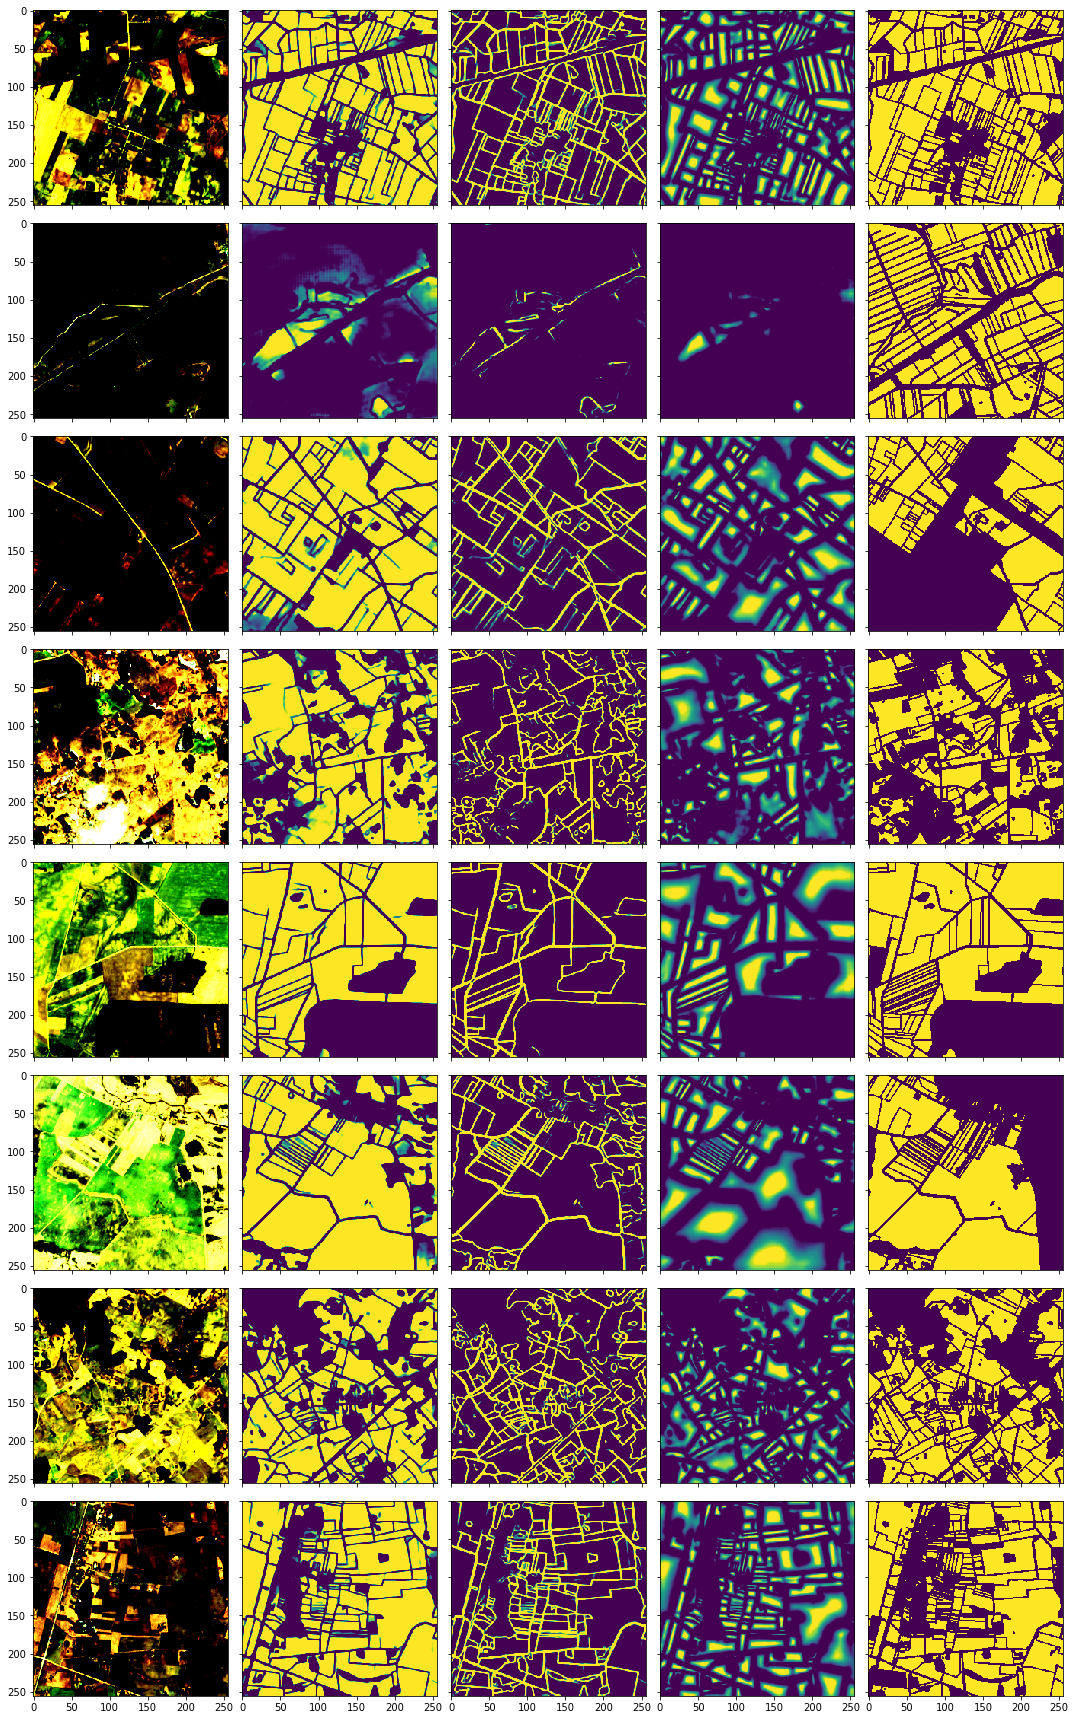

In [34]:
n_images = 8

fig, axs = plt.subplots(nrows=n_images, ncols=5, sharex='all', sharey='all', figsize=(15, 3*n_images))

for nb in np.arange(n_images):
    axs[nb][0].imshow(cval_batch[0]['features'].numpy()[nb][...,[2,1,0]])
    axs[nb][1].imshow(predictions[0][nb][..., 1])
    axs[nb][2].imshow(predictions[1][nb][..., 1])
    axs[nb][3].imshow(predictions[2][nb][..., 1])
    axs[nb][4].imshow(cval_batch[1]['extent'].numpy()[nb][..., 1])
    
plt.tight_layout()

From savedModel

In [ ]:
# new_model_2 = tf.keras.models.load_model(f'{checkpoint_path}/saved_model/', compile=False)

In [ ]:
# new_model_2.evaluate(cval_dataset)